# Evaluation of Best Models on New Bitcoin Fee Data (Mar 5 – May 12)

This notebook evaluates the best-performing model from each class on the latest cleaned dataset:

- Exponential Smoothing (HWES)
- SARIMA
- XGBoost

Each model uses a dedicated preprocessed feature set. Evaluation is done using MAE and RMSE on the test set. Visual comparisons are provided.

## 1. Import Libraries

In [101]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## 2. Load Preprocessed Datasets

In [3]:
df_hwes = pd.read_parquet("../data/processed/preprocessed_hwes.parquet")
df_sarima = pd.read_parquet("../data/processed/preprocessed_sarima.parquet")
df_xgb = pd.read_parquet("../data/processed/preprocessed_xgboost.parquet")

## 3. Forecasting with Best-Performing Models Across Methods

### 3.1 HWES Model

#### 3.1.1 HWES Model – 15-Minute Interval  
Evaluate performance using the best parameters on the 15-minute preprocessed dataset.


In [78]:
df_15min = df_hwes.resample("15min").mean().interpolate()

# Select target
target_col = "recommended_fee_fastestFee"
series_15min = df_15min[[target_col]]

# We use the global median of the unscaled 15-minute series as a simple baseline. This constant prediction serves as a reference point to evaluate the effectiveness of our forecasting models. The error is computed on the original scale (sat/vByte).
# Define forecast horizon (24h = 96 points for 15-min interval)
forecast_horizon = 96

# Split into training (all but last day) and testing (last day)
train_full = series_15min[:-forecast_horizon]
test = series_15min[-forecast_horizon:]

# Compute and print global median
global_median = train_full.median().item()
print(f"Global median: {global_median:.2f}")

# Predict using constant median value
pred_base = pd.Series(global_median, index=test.index)

# Evaluate in original scale
base_mae = mean_absolute_error(test, pred_base)
base_rmse = mean_squared_error(test, pred_base) ** 0.5
base_mape = mean_absolute_percentage_error(test, pred_base) * 100

# Print results
print(f"Baseline MAE: {base_mae:.4f}")
print(f"Baseline RMSE: {base_rmse:.4f}")
print(f"Baseline MAPE: {base_mape:.4f}%")

Global median: 3.00
Baseline MAE: 5.6146
Baseline RMSE: 12.0169
Baseline MAPE: 67.7478%


In [79]:

# Step 1: Define parameter grid
# trend_options = ['add', 'mul']
# seasonal_options = ['add', 'mul']
# damped_options = [True, False]

# param_grid = [
#     (t, s, d)
#     for t in trend_options
#     for s in seasonal_options
#     for d in damped_options
#     if not (t == 'mul' or s == 'mul') or (series_15min_scaled > 0).all()
# ]

# # Step 2: Grid search on training set
# best_mae = float('inf')
# best_params = None

# for trend, seasonal, damped in param_grid:
#     try:
#         model = ExponentialSmoothing(
#             train_15,
#             trend=trend,
#             seasonal=seasonal,
#             seasonal_periods=96,
#             damped_trend=damped
#         )
#         fit = model.fit(optimized=True, use_brute=True)
#         forecast = fit.forecast(96)
#         mae = mean_absolute_error(test_15, forecast)

#         if mae < best_mae:
#             best_mae = mae
#             best_params = (trend, seasonal, damped)

#     except Exception as e:
#         print(f"Skipped: {trend}-{seasonal}-{damped} due to {e}")

# Step 3: Retrain final model on full train set using best_params
# best_trend, best_seasonal, best_damped = best_params
# Normalize the target to [0, 1]
scaler = MinMaxScaler(feature_range=(1, 2))
series_15min_scaled = scaler.fit_transform(series_15min)
series_15min_scaled = pd.Series(series_15min_scaled.flatten(), index=series_15min.index)

# Step 3: Use full historical data (except last 24h) for training; last 24h for testing
train_15 = series_15min_scaled[:-96]
test_15 = series_15min_scaled[-96:]

# Fit the model
final_model = ExponentialSmoothing(
    train_15,
    trend='mul',
    seasonal='mul',
    seasonal_periods=96,
    damped_trend=True
)
final_fit = final_model.fit(optimized=True, use_brute=True)
forecast_final = final_fit.forecast(96)


In [80]:
# Inverse transform
train_15_true = scaler.inverse_transform(train_15.values.reshape(-1, 1)).flatten()
test_15_true = scaler.inverse_transform(test_15.values.reshape(-1, 1)).flatten()
forecast_15 = scaler.inverse_transform(forecast_final.values.reshape(-1, 1)).flatten()

# Evaluation
mae_15 = mean_absolute_error(test_15_true, forecast_15)
rmse_15 = mean_squared_error(test_15_true, forecast_15) ** 0.5
mape_15 = mean_absolute_percentage_error(test_15_true, forecast_15) * 100

print(f"HWES 15min MAE: {mae_15:.2f}")
print(f"HWES 15min RMSE: {rmse_15:.2f}")
print(f"HWES 15min MAPE: {mape_15:.2f}%")

HWES 15min MAE: 5.44
HWES 15min RMSE: 11.53
HWES 15min MAPE: 75.39%


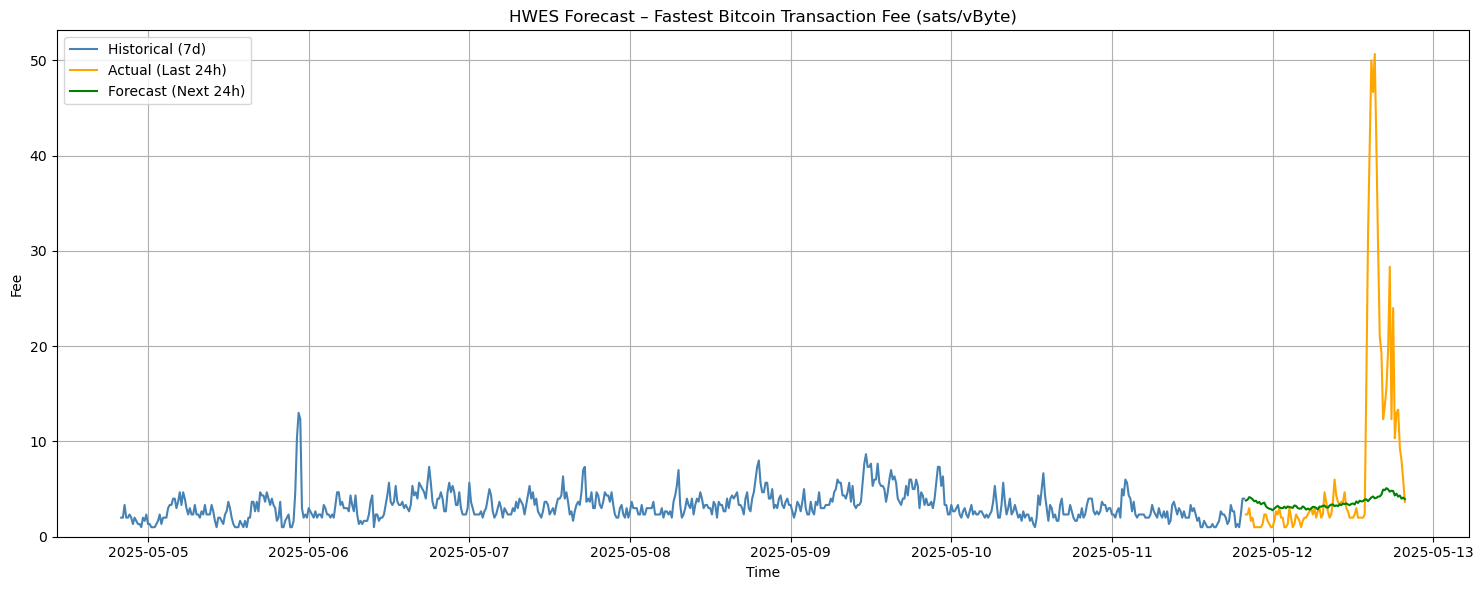

In [105]:
# Plot last 7 days (train), actual last 24h, and forecast
plt.figure(figsize=(15, 6))
plt.plot(train_15.index[-96*7:], train_15_true[-96*7:], label="Historical (7d)", color="steelblue")
plt.plot(test_15.index, test_15_true, label="Actual (Last 24h)", color="orange")
plt.plot(test_15.index, forecast_15, label="Forecast (Next 24h)", color="green")
plt.title("HWES Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 3.1.2 HWES Model – 30-Minute Interval  
Compare results using the same model on the 30-minute resampled dataset, which may reduce noise and improve generalization.

In [84]:
df_30min = df_hwes.resample("30min").mean().interpolate()

# Select target
target_col = "recommended_fee_fastestFee"
series_30min = df_30min[[target_col]]

# Normalize the target to [0, 1]
scaler = MinMaxScaler(feature_range=(1, 2))
series_30min_scaled = scaler.fit_transform(series_30min)
series_30min_scaled = pd.Series(series_30min_scaled.flatten(), index=series_30min.index)

# Step 3: Train on full data except the last 48 points (24 hours); test on the last 48 points
train_30 = series_30min_scaled[:-48]
test_30 = series_30min_scaled[-48:]

# Fit HWES with best params
model_30 = ExponentialSmoothing(
    train_30,
    trend='mul',
    seasonal='mul',
    seasonal_periods=48,
    damped_trend=True
)
fit_30 = model_30.fit(optimized=True, use_brute=True)
forecast_scaled = fit_30.forecast(48)

# Inverse transform
forecast_30 = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1)).flatten()
test_30_true = scaler.inverse_transform(test_30.values.reshape(-1, 1)).flatten()

# Evaluation
mae_30 = mean_absolute_error(test_30_true, forecast_30)
rmse_30 = mean_squared_error(test_30_true, forecast_30) ** 0.5
mape_30 = mean_absolute_percentage_error(test_30_true, forecast_30) * 100

print(f"HWES 30min MAE: {mae_30:.2f}")
print(f"HWES 30min RMSE: {rmse_30:.2f}")
print(f"HWES 30min MAPE: {mape_30:.2f}%")


HWES 30min MAE: 5.31
HWES 30min RMSE: 11.47
HWES 30min MAPE: 59.21%


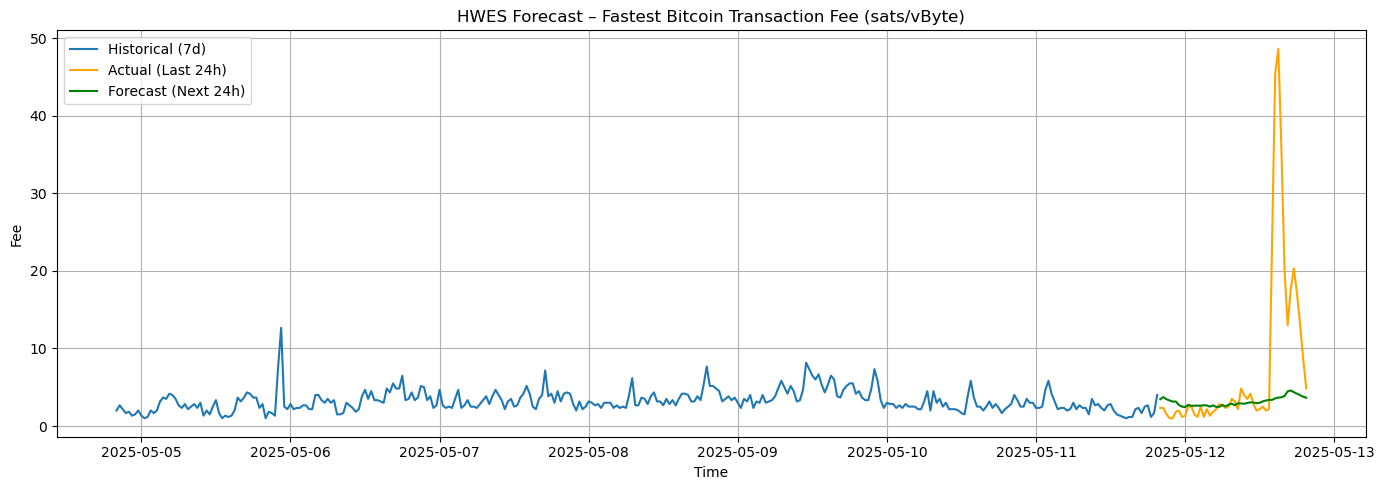

In [85]:
# Plot
plt.figure(figsize=(14, 5))
plt.plot(train_30.index[-48*7:], scaler.inverse_transform(train_30[-48*7:].values.reshape(-1, 1)), label="Historical (7d)")
plt.plot(test_30.index, test_30_true, label="Actual (Last 24h)", color="orange")
plt.plot(test_30.index, forecast_30, label="Forecast (Next 24h)", color="green")
plt.title("HWES Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.2 SARIMA

=== SARIMA Model (7-day train) ===
RMSE: 12.0178
MAE: 5.6449
MAPE: 69.71%

=== Baseline (Median) ===
RMSE: 12.0169
MAE: 5.6146
MAPE: 67.75%


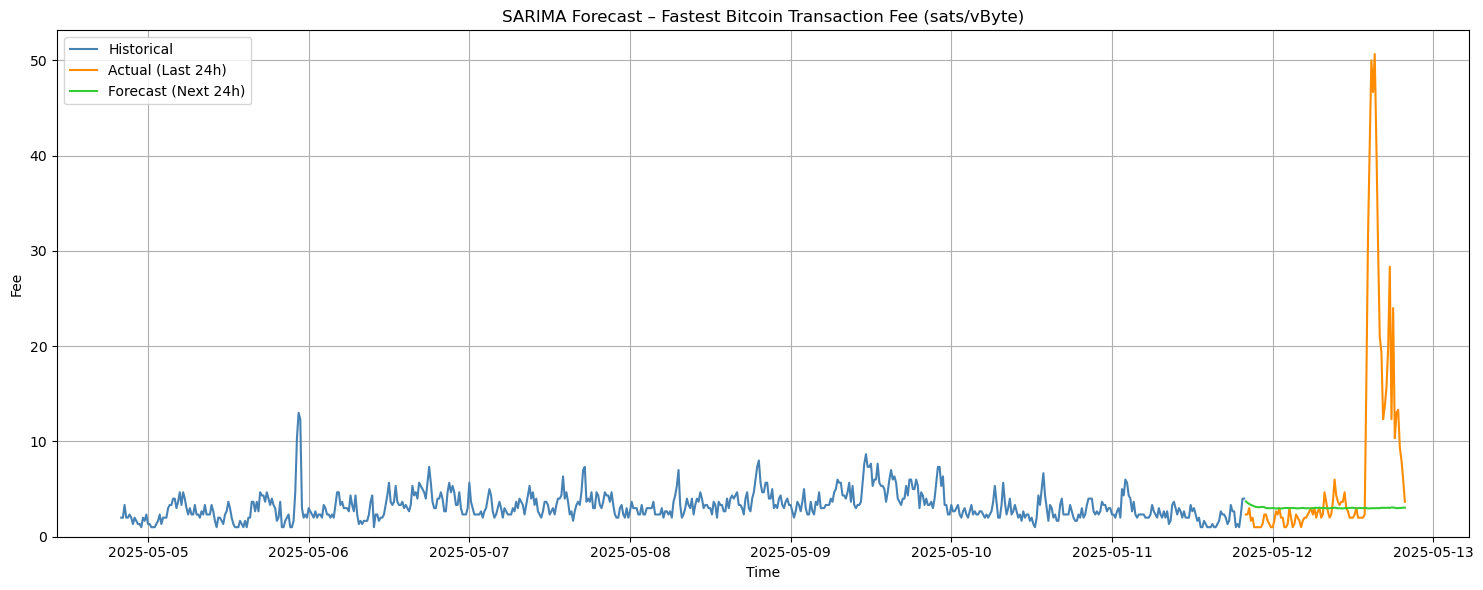

In [86]:
# Use last 8 days (7 for training, 1 for testing)
y = df_sarima["recommended_fee_fastestFee"]

# 15-min interval: 96 points/day, so 8 days = 768 points
y_recent = y[-768:]
y_train = y_recent[:-96]
y_test = y_recent[-96:]

# Log transform
y_train_log = np.log1p(y_train)

# Fit SARIMA
forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))
forecaster.fit(y_train_log)

# Forecast
fh = list(range(1, 97))
y_pred_log = forecaster.predict(fh=fh)
y_pred = np.expm1(y_pred_log)

# Baseline
baseline_value = y_train.median()
y_pred_baseline = [baseline_value] * 96

# Metrics
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

baseline_rmse = mean_squared_error(y_test, y_pred_baseline) ** 0.5
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

# Print results
print("=== SARIMA Model (7-day train) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2%}")
print("\n=== Baseline (Median) ===")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")
print(f"MAPE: {baseline_mape:.2%}")

# Plot
# Use the last 8 days to extract this 7+1 split
series_recent = y_recent                # Last 8 days
train_plot = series_recent[:-96]       # First 7 days
test_plot = series_recent[-96:]        # Last day

plt.figure(figsize=(15, 6))
plt.plot(train_plot.index, train_plot, label="Historical", color="steelblue")
plt.plot(test_plot.index, y_test, label="Actual (Last 24h)", color="darkorange")
plt.plot(test_plot.index, y_pred, label="Forecast (Next 24h)", color="limegreen")

plt.title("SARIMA Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.3 XGBoost

In [102]:
# Step 1: Define target column
target_col = "recommended_fee_fastestFee"

# Step 2: Shift external (non-lag) features forward by 96 steps (24h)
non_lag_cols = [col for col in df_xgb.columns if "lag" not in col and col != target_col]
df_xgb[non_lag_cols] = df_xgb[non_lag_cols].shift(96)

# Step 3: Drop rows with NaNs after shifting
df_xgb.dropna(inplace=True)

# Step 4: Define X and y
y = df_xgb[target_col]
X = df_xgb.drop(columns=[target_col])

# Step 5: Forecast horizon: last 96 = 24h
forecast_horizon = 96
y_train, test_xgb_true = y[:-forecast_horizon], y[-forecast_horizon:]
X_train, X_test = X[:-forecast_horizon], X[-forecast_horizon:]

# Step 6: Define and fit XGBoost forecaster
best_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_estimators=150,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=10,
    reg_alpha=10,
    gamma=5,
    n_jobs=-1
)

forecaster = make_reduction(
    estimator=best_xgb,
    window_length=96,
    strategy="recursive",
    scitype="infer"
)

fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)
forecaster.fit(y_train, X=X_train)
forecast_xgb = forecaster.predict(fh=fh, X=X_test)

# Step 7: Evaluate
mae = mean_absolute_error(test_xgb_true, forecast_xgb)
rmse = mean_squared_error(test_xgb_true, forecast_xgb) ** 0.5
mape = mean_absolute_percentage_error(test_xgb_true, forecast_xgb) * 100

print(f"XGBoost 15min MAE: {mae:.2f}")
print(f"XGBoost 15min RMSE: {rmse:.2f}")
print(f"XGBoost 15min MAPE: {mape:.2f}%")


XGBoost 15min MAE: 5.57
XGBoost 15min RMSE: 12.11
XGBoost 15min MAPE: 52.95%


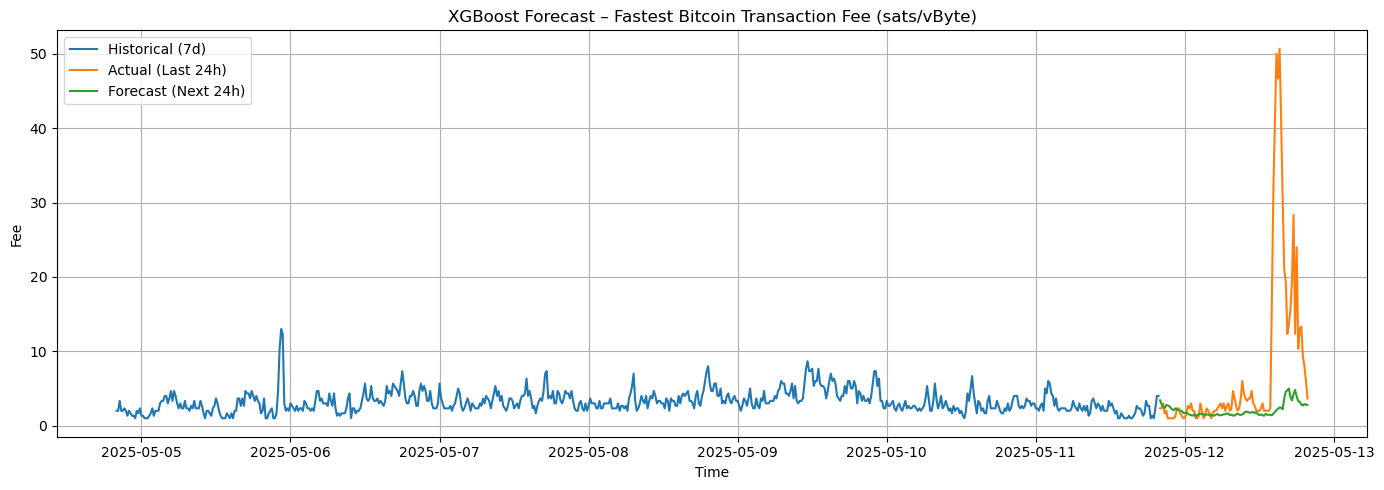

In [103]:
plt.figure(figsize=(14, 5))
plt.plot(y_train.index[-96*7:], y_train[-96*7:], label="Historical (7d)")
plt.plot(test_xgb_true.index, test_xgb_true, label="Actual (Last 24h)")
plt.plot(test_xgb_true.index, forecast_xgb, label="Forecast (Next 24h)")
plt.title("XGBoost Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Compare results

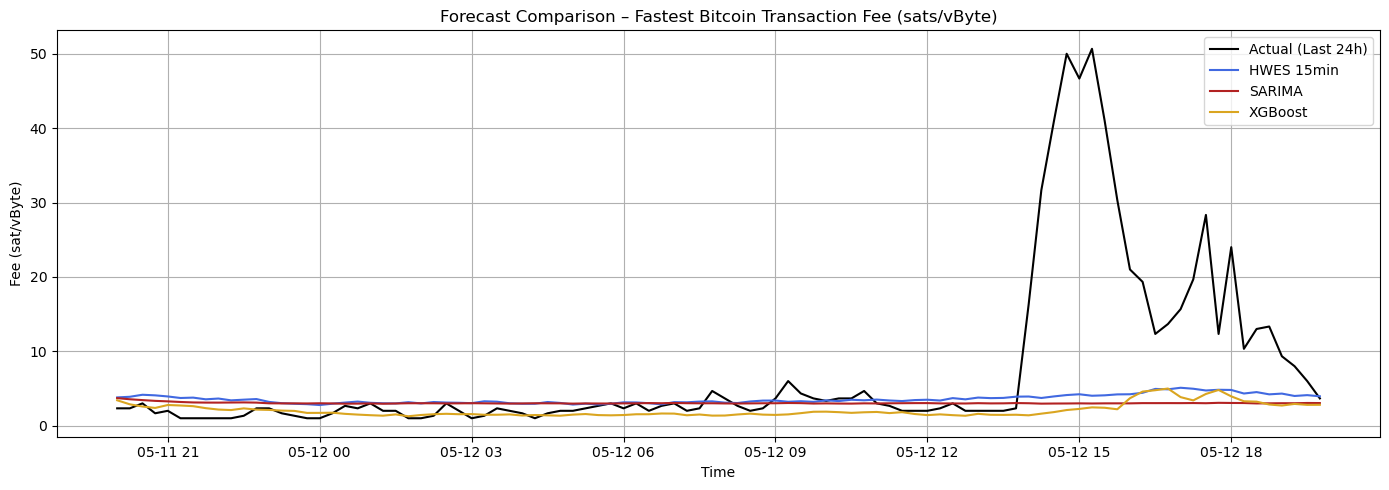

In [104]:
# Plot: Final 1-day actual + forecast from best models
plt.figure(figsize=(14, 5))

# Plot actual (last 24h)
plt.plot(test_15.index, test_15_true, label="Actual (Last 24h)", color="black")

# Forecasts from best models
plt.plot(test_15.index, forecast_15, label="HWES 15min", color="royalblue")
plt.plot(y_test.index, y_pred, label="SARIMA", color="firebrick")
plt.plot(test_xgb_true.index, forecast_xgb, label="XGBoost", color="goldenrod")

# Final touches
plt.title("Forecast Comparison – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee (sat/vByte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Forecast Comparison Insight

The plot compares the performance of three forecasting models on the final 24-hour period of the fastest Bitcoin transaction fee (sats/vByte):

- **HWES (blue)**  
  Captures general seasonal patterns, but fails to respond to abrupt fee spikes. It underestimates the sudden surge, indicating it's more suitable for smoother, trend-like series.

- **SARIMA (red)**  
  Outputs a flat forecast, showing poor responsiveness to recent changes. This confirms its limitation in handling volatile or non-stationary data, even when trained on expanding windows.

- **XGBoost (gold)**  
  Demonstrates the best adaptability. It reacts to the trend break and rising fee levels more effectively than the statistical models, despite slightly underestimating the exact peak. This is likely due to its ability to leverage lagged features and full historical context.

---

**🔍 Insight:**  
**XGBoost provides the most flexible and reactive forecasts**, making it better suited for datasets with structural breaks or sudden volatility. In contrast, traditional time series models like HWES and SARIMA tend to smooth out spikes and lag behind trend reversals.
